# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 109 ms, sys: 14.4 ms, total: 123 ms
Wall time: 147 ms


In [4]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 15s, sys: 4.76 s, total: 3min 20s
Wall time: 3min 21s


In [5]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 52s, sys: 3.61 s, total: 1min 56s
Wall time: 1min 56s


In [6]:
X = {}
X['model a'] = covariates
X['model b'] = pd.concat([covariates,expression], axis=1)
for k in ['model a','model b']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)


In [7]:
mutations = {
    '7157': 'TP53',   # tumor protein p53
    '7428': 'VHL',    # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1',   # BRCA1, DNA repair associated
    '675': 'BRCA2',   # BRCA2, DNA repair associated
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1',   # menin 1
    '5979': 'RET',    # ret proto-oncogene
}

## Median absolute deviation feature selection

In [8]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [29]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': 10.0 ** np.linspace(-3, 1, 10),
    'classify__l1_ratio': [0.15],
}

expression_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(lambda X: X[:,covariates.shape[1]:])),
    ('select', SelectKBest(fs_mad,2000)),
])

covariate_feats = Pipeline(steps=[
    ('dim_red', FunctionTransformer(lambda X: X[:,:covariates.shape[1]])),
])

combo_pipeline = Pipeline([
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('features', FeatureUnion([
        ('covariates_feats', covariate_feats),           
        ('expression_feats', expression_feats)
    ])),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

covariates_pipeline = Pipeline(steps=[
    ('imputer', Imputer()),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

In [30]:
cv_pipeline = {}
cv_pipeline['model a'] = GridSearchCV(estimator=covariates_pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model b'] = GridSearchCV(estimator=combo_pipeline, param_grid=param_grid, scoring='roc_auc')

## Functions to get statistics for a given model 

In [39]:
# Get statistics for a given model. 

def get_aurocs(X, y, pipeline, series, model_type):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df = grid_scores_to_df(pipeline.grid_scores_)
    coeff_df = get_coeffs(pipeline, X_train, model_type)
    n_pos, n_neg = get_sign_coeffs(coeff_df)
    cov_ranks = get_ranks_covariates_feat(coeff_df)
    series['mean_cv_auroc'] = cv_score_df.score.max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    series['n_pos_coeffs'] = n_pos
    series['n_neg_coeffs'] = n_neg
    series['n_positive_mutation'] = sum(y==1)
    series['n_negative_mutation'] = sum(y==0)
    series['cum_rank_cov_feat'] = cov_ranks.sum()
    series['median_rank_cov_feat'] = np.median(cov_ranks)
    series['mean_rank_cov_feat'] = np.mean(cov_ranks)
    return series

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_coeffs(pipeline, X_train, model_type):
    """
    Get a dataframe with the training coefficients 
    """
    final_pipeline = pipeline.best_estimator_
    final_classifier = final_pipeline.named_steps['classify']
    
    # Get indices of features
    if model_type == 'model a': 
        select_indices = list(range(len(covariates.columns.values)))
    else:
        select_indices = final_pipeline.named_steps['features'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
        select_indices = [x for sublist in select_indices for x in sublist]
    
    # Make df features, weights
    coef_df = pd.DataFrame.from_items([
        ('feature', X_train.columns[select_indices]),
        ('weight', final_classifier.coef_[0]),
    ])

    return coef_df

def get_sign_coeffs(coef_df):
    return (coef_df.weight>0).sum(), (coef_df.weight<0).sum()

def get_ranks_covariates_feat(coef_df):
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    def RepresentsInt(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False

    coef_df['is_cov_feat'] = [not RepresentsInt(x) for x in coef_df['feature']]
    ranks = np.flatnonzero(coef_df['is_cov_feat'])
    return ranks

auroc_dfs = {}

## Train the models.

In [40]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model a'], Y[m], cv_pipeline['model a'], series, 'model a'))
auroc_dfs['model a'] = pd.DataFrame(rows)
auroc_dfs['model a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
display(auroc_dfs['model a'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
5,238,ALK,0.840648,0.500000,0.500000,0,0,138,7168,2415,34.5,34.5
3,672,BRCA1,0.859306,0.500000,0.500000,0,0,136,7170,2415,34.5,34.5
6,675,BRCA2,0.872013,0.811153,0.790877,1,0,237,7069,2415,34.5,34.5
1,29126,CD274,0.887013,0.870971,0.933095,3,0,19,7287,2415,34.5,34.5
2,4221,MEN1,0.849791,0.804713,0.738397,4,6,57,7249,2415,34.5,34.5
4,5979,RET,0.854921,0.806310,0.756233,3,0,117,7189,2415,34.5,34.5
7,7157,TP53,0.851322,0.849591,0.844948,23,32,2587,4719,2415,34.5,34.5
0,7428,VHL,0.990092,0.989094,0.949362,11,10,135,7171,2415,34.5,34.5


CPU times: user 30.7 s, sys: 1.96 s, total: 32.7 s
Wall time: 16.9 s


In [12]:
%%time
# Train model b: covariates with gene expression data.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    rows.append(get_aurocs(X['model b'], Y[m], cv_pipeline['model b'], series, 'model b'))
auroc_dfs['model b'] = pd.DataFrame(rows)
auroc_dfs['model b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)

CPU times: user 58min 51s, sys: 36min 23s, total: 1h 35min 14s
Wall time: 1h 38min 56s


In [34]:
auroc_dfs['model a']['model'] = 'covariates_only'
auroc_dfs['model b']['model'] = 'combined'
auroc_df = pd.concat([auroc_dfs['model a'],auroc_dfs['model b']])
auroc_df.to_csv("./auroc_df.tsv", sep="\t", float_format="%.3g", index=False)
auroc_df.head(2)

KeyError: 'model b'

In [19]:
auroc_dfs['diff_models_ab'] = auroc_dfs['model b'].loc[:,'mean_cv_auroc':]-auroc_dfs['model a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_models_ab'][['mutation', 'symbol']] = auroc_dfs['model b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_models_ab']

,mean_cv_auroc,training_auroc,testing_auroc,n_pos_coeffs,n_neg_coeffs,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,mutation,symbol
5,-0.004248,0.106221,-0.081391,71,84,84808,1375.0,1211.542857,238,ALK
3,-0.005017,0.000000,0.000000,0,0,91557,1353.0,1307.957143,672,BRCA1
6,0.000000,0.002566,0.001637,4,1,90210,1355.0,1288.714286,675,BRCA2
1,0.000000,0.006184,0.015565,2,1,89728,1355.0,1281.828571,29126,CD274
2,-0.027329,-0.025882,-0.007893,3,-21,89897,1357.0,1284.242857,4221,MEN1
4,-0.009987,-0.040952,0.028069,-1,-18,91726,1354.0,1310.371429,5979,RET
7,0.086714,0.099317,0.084897,231,151,64784,1422.0,925.485714,7157,TP53
0,0.006821,0.014251,0.000131,158,104,86631,1399.0,1237.585714,7428,VHL


# Covariates only vs covariates+expression model

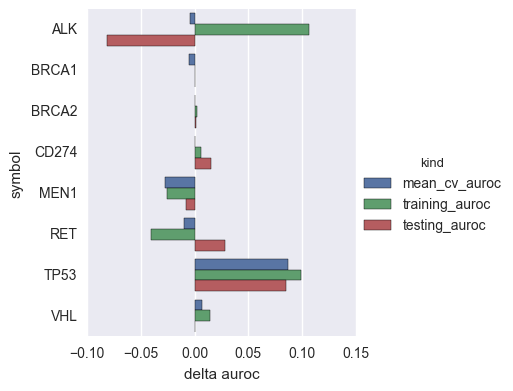

In [20]:
plot_df = pd.melt(auroc_dfs['diff_models_ab'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='delta auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")